# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


## TD8 : Modèles bayésiens pour la loi normale

Dans ce TD, nous implémenterons l'échantillonnage de Gibbs permettant d'otenir un échantillon aléatoire à partir de la forme fonctionnelle d'une loi de probabilité multidimensionnelle. Nous effectuerons également la sélection de modèle bayésienne de modèle statistique. La lecture du chapitre 6 des notes de cours vous sera très utile.

Nous reprenons les observations de l'expérience de Michelson-Morley prises par Illingworth en 1927.

In [1]:
# Chargement des librairies nécessaires
using CSV, DataFrames, Gadfly, Statistics, Distributions

## Exercice 1 : Expérience de Michelson-Morley (avec variance inconnue)

On a que

$$ Y_i \sim \mathcal{N} \left( \mu, \sigma^2 \right) ; $$

avec la variance inconnue. On utilise la loi *a priori* impropre suivante pour les paramètres $\mu$ et $\sigma^2$ :

$$f_{(\mu,\sigma^2)}(\mu,\sigma^2) \propto \frac{1}{\sigma^2} \mbox{ pour }\sigma^2 >0. $$

Nous utiliserons l'échantillonnage de Gibbs pour obtenir un échantillon de la loi *a posteriori*.

In [2]:
# Chargement des données
data = CSV.read("illingworth1927.csv", DataFrame)

df = filter(row -> (row.Time == "5 a.m.") & (row.Direction =="N"), data )
y = df[:,:FringeDispl]

ȳ = mean(y)
s = std(y)
n = length(y)

6

### (a) Écrivez la loi conditionnelle complète de $\mu$.

On veut une fonction qui retourne la loi conditionnelle complète de μ pour une valeur de σ² donnée. La fonction doit retourner un objet de type *Distribution*. 

In [3]:
f₁(σ²::Real) = Normal(ȳ, sqrt(σ²/n))

f₁ (generic function with 1 method)

### (b) Écrivez la loi conditionnelle complète de $\sigma^2$.

On veut une fonction qui retourne la loi conditionnelle complète de σ² pour une valeur de μ donnée. La fonction doit retourner un objet de type *Distribution*. 

In [4]:
f₂(μ::Real) = InverseGamma(n/2, sum( (y[i]-μ)^2 for i=1:n)/2 )

f₂ (generic function with 1 method)

### (c) Générez un échantillon aléatoire de la loi *a posteriori*.

À l'aide des lois conditionnelles complètes, faites 1000 itérations de l'échantillonnage de Gibbs pour générer un échantillon de la loi *a posteriori*. Vous pouvez initialiser μ et σ² à des valeurs quelconques. 

In [5]:
# Nombre d'itérations
m = 1000

# Initialisation des vecteurs
μ = zeros(m)
σ² = zeros(m)

# Définition des états initiaux (valeurs arbitraires)
μ[1] = 10
σ²[1] = 10

# Itérations de l'échantillonnage de Gibbs
for i=2:m
    
    μ[i] = rand( f₁(σ²[i-1]) )

    σ²[i] = rand( f₂(μ[i]) )
    
end

### (d) Tracez la chaîne obtenue pour $\mu$.

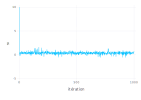

In [6]:
plot(x=1:length(μ), y=μ, Geom.line, 
    Guide.xlabel("itération"), Guide.ylabel("μ"))

### (e) Tracez la chaîne obtenue pour $\sigma^2$.

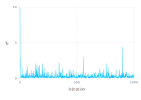

In [7]:
plot(x=1:length(σ²), y=σ², Geom.line,
    Guide.xlabel("itération"), Guide.ylabel("σ²"))

### (f) Rejetez les itérations de la phase de chauffe

In [8]:
# Ici, la phase de chauffe est très courte. Elle se termine après quelques itérations seulement

#= On supprime les 100 premières itérations pour être certain de ne récupérer que les valeurs
 de la phase d'échantillonnage =#
deleteat!(μ,(1:100))
deleteat!(σ²,(1:100))

900-element Vector{Float64}:
 0.5591253594541838
 0.3294314657665232
 1.1544480207062642
 0.1708031678686558
 0.23989355831119563
 0.36993337477042104
 0.16505073741701262
 0.29411945497173964
 0.11595025414480892
 0.1433344033041787
 0.7381404629027886
 0.14942534964817394
 0.3061114374659953
 ⋮
 0.0890570467154649
 0.24698249667943564
 0.19368552822463056
 0.07523209063597645
 0.15595393941920765
 0.06930924126802837
 0.13244309251469746
 0.43832687370819823
 0.2170453905623891
 0.6832226077993417
 0.26236961074326026
 0.5007039943008325

### (f) Calculez la loi *a posteriori* marginale de μ

Cette loi est donnée dans l'exemple 2 des notes de cours. Calculez ses paramètres et construisez l'objet de type *UnivariateDistribution* en utiisant la fonction `LocationScale()`.

In [9]:
f = LocationScale(ȳ, s/sqrt(n), TDist(n-1))

LocationScale{Float64, TDist{Float64}}(
μ: 0.36666666666666664
σ: 0.18262286579481526
ρ: TDist{Float64}(ν=5.0)
)


### (g) Vérifiez que la chaine générée pour μ correspond à la loi marginale

Pour vérifier que votre chaîne μ générée correspond à la loi *a posteriori* marginale de μ, comparez la densité de la loi que vous avez obtenue à la question précédente à l'histogramme de la chaine des μ. Vous pouvez même superposer la densité à l'histogramme sur le même graphique en utilisant la fonction `layer()` de Gadfly et l'option `density=true` de la géométrie `Geom.histrogram()`.

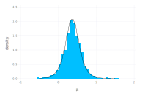

In [10]:
plot(
    layer(x->pdf(f, x), -.5, 1.5, Theme(default_color=colorant"black")),
    layer(x=μ, Geom.histogram(bincount=30, density=true)),
    Guide.xlabel("μ"), Guide.ylabel("density")
)

## Exercice 2 : Détermination de la variance de l'erreur du montage d'Illingworth

On sait aujourd'hui que le vrai déplacement des franges d'interférence est égal à 0, peu importe les conditions d'observation. On peut alors supposer le modèle suivant pour estimer la variance de l'erreur expérimentale du montage

$$ Y_i \sim \mathcal{N} \left( 0, \sigma^2 \right) ; $$

pour les 64 observations effectuées.

Nous allons d'abord vérifier si Illingworth a bien estimé l'erreur de son montage en comparant les modèles satistiques suivants :

$$ \mathcal{M}_1 : Y_i \sim \mathcal{N} \left( 0, (3/2)^2 \right) , $$
$$ \mathcal{M}_2 : Y_i \sim \mathcal{N} \left( 0, \sigma^2 \right) ; $$

le modèle $\mathcal{M}_1$ correspond à l'hypothèse d'Illingworth et le modèle $\mathcal{M}_2$ suppose une variance d'erreur différente. Si le modèle $\mathcal{M}_2$ est plus vraisemblable, alors nous estimerons la variance expérimentale du montage.

In [11]:
y = data[:,:FringeDispl]

ȳ = mean(y)
s = std(y)
n = length(y)

64

### (a) Calculez la log vraisemblance du modèle $\mathcal{M}_1$

In [12]:
lf1 = loglikelihood(Normal(0,3/2),y)

-87.13081082179936

### (b) Calculez le bic du modèle $\mathcal{M}_1$

In [13]:
k = 0
bic1 = lf1 - k/2*log(n)

-87.13081082179936

### (c) Calculez l'estimation du maximum de la vraisemblance de σ²

Vous devez calculez à main la formule de l'estimateur en dérivant la vraisemblance puis calculez l'estimation avec les données.

L'estimateur du maximum de la vraisemblance est

$$ \hat\sigma^2 = \frac{1}{n} \sum_{i=1}^n y_i^2. $$

In [14]:
σ̂² = sum(y.^2)/n

0.16656875000000004

### (d) Calculez la log-vraisemblance du modèle $\mathcal{M}_2$ évaluée à σ̂²

In [15]:
lf2 = loglikelihood(Normal(0,sqrt(σ̂²)), y)

-33.45695758513737

### (e) Calculez le BIC du modèle $\mathcal{M}_2$

In [16]:
k = 1
bic2 = lf2 - k/2*log(n) 

-35.5363991268172

### (f) Quel est le meilleur modèle ?

Selon les BIC calculés, quel est le meilleur modèle ?

In [17]:
bic2-bic1

51.594411694982156

Puisque la bic2 - bic1 > 2, la certitude que $\mathcal{M}_1$ est faux par rapport à $\mathcal{M}_2$ est **décisive**. Le meilleur modèle est sans aucun doute $\mathcal{M}_2$.

### (g) Estimez l'écart-type expériemental σ du montage d'Illingworth

In [18]:
σ̂ = sqrt(σ̂²)

0.4081283499096823